In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [28]:
import numpy as np
import altair as alt
import pandas as pd

from scipy.sparse import lil_matrix
from annoy import AnnoyIndex
from collections import defaultdict
from titlecase import titlecase
from umap import UMAP

from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.decomposition import PCA

from sqlalchemy.dialects.postgresql import array_agg
from sqlalchemy.sql import functions as func

from osp_graphs.v1_db import session, Text, Field, Subfield, SubfieldDocument, Citation, Document

In [52]:
count = func.count(Citation.text_id)

titles, surnames, text_doc_ids = zip(*session
    .query(Text.title, Text.surname, array_agg(Citation.document_id))
    .join(Citation)
    .filter(Text.valid==True)
    .filter(Text.display==True)
    .group_by(Text.id)
    .order_by(count.desc())
    .limit(1000)
    .all())

In [53]:
doc_ids = list(set([did for doc_ids in text_doc_ids for did in doc_ids]))
doc_id_to_idx = {did: i for i, did in enumerate(doc_ids)}

In [54]:
M = np.zeros((len(doc_ids), len(surnames)))

for sidx, doc_ids in enumerate(text_doc_ids):
    for did in doc_ids:
        didx = doc_id_to_idx[did]
        M[didx][sidx] += 1

In [55]:
M.sum()

570610.0

In [56]:
svd = TruncatedSVD(n_components=10)

In [57]:
svd.fit(M)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)

In [58]:
svd.components_.T.shape

(1000, 10)

In [107]:
dr = manifold.TSNE(n_components=2, init='pca', metric='cosine', random_state=1)

In [116]:
embedding = dr.fit_transform(svd.components_.T)

In [86]:
embedding = UMAP().fit_transform(svd.components_.T)

In [117]:
rows = []
for title, surname, (x, y) in zip(titles, surnames, embedding):
    rows.append(dict(surname=surname, title=title, x=x, y=y))

In [118]:
df = pd.DataFrame(rows)

In [119]:
df.surname = df.surname.apply(lambda s: s.capitalize())

In [120]:
df.title = df.title.apply(lambda t: titlecase(t.strip(' /;.')))

In [125]:
chart = (alt
    .Chart(df, width=1000, height=700)
    .mark_text()
    .encode(x='x', y='y', text='surname', tooltip='title'))

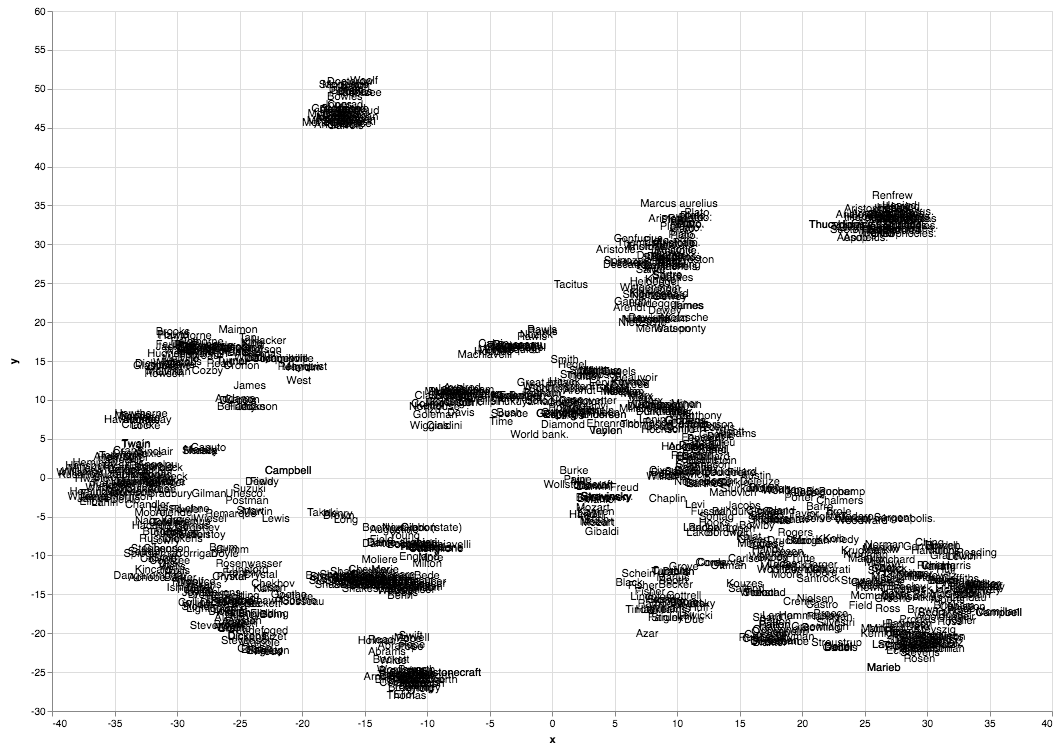

In [126]:
chart.interactive()